In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')
import pixiedust

Pixiedust database opened successfully


In [2]:
n_samples = 10
X_p = np.linspace(0, 1, n_samples)
Y_p = np.linspace(0, 1, n_samples)
X_p, Y_p = np.meshgrid(X_p, Y_p)
X_p = X_p.flatten()
Y_p = Y_p.flatten()
samples = np.array([X_p, Y_p]).T

## Example 7

$$\Delta\Psi(x, y)=\sin(\pi x)\left(2-\pi^2y^2\right)$$

With boundary conditions $\Psi(0,y)=0$, $\Psi(1, y)=0$, $\Psi(x, 0)=0$, and $\frac{\partial}{\partial y}\Psi(x, 1)=2\sin(\pi x)$.

The trial solution for this case is $\Psi(x, y)=A(x, y) + B(x, y)[N(x, y) - N(x, 1) - \frac{\partial N}{\partial y}(x, 1)]$ with $B(x)=x(1-x)y$ and $A(x, y)= 2y\sin(\pi x).$

In [3]:
def example7_boundary_value(point):
  x = point[0]
  y = point[1]
  return 2 * y * np.sin(np.pi * x)

In [4]:
def example7_boundary_vanishing(point):
  x = point[0]
  y = point[1]
  return x * (1 - x) * y

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(\Delta\Psi(x_i, N(x_i))-\sin(\pi x)\left(2-\pi^2y^2\right) \right)^2$$
And the Laplace operator term acting on the trial solution becomes:
$$\Delta\Psi(x_i, N(x_i))=\Delta A(x,y) + \Delta \left(x(1-x)y\left[N(x, y) - N(x, 1) - \frac{\partial N}{\partial y}(x, 1)\right]\right)$$
$$=-2\pi^2y\sin(\pi x) +2x(1-x)\frac{\partial N}{\partial y}(x, y) +x(1-x)y\frac{\partial^2 N}{\partial y^2}(x, y)- 2y \left[N(x, y) - N(x, 1) - \frac{\partial N}{\partial y}(x, 1)\right] + 2y(1-2x) \left[\frac{\partial N}{\partial x}(x, y) - \frac{\partial N}{\partial x}(x, 1) - \frac{\partial^2 N}{\partial x\partial y}(x, 1)\right] +x(1-x)y\left[\frac{\partial^2 N}{\partial x^2}(x, y) - \frac{\partial^2 N}{\partial x^2}(x, 1) - \frac{\partial^3 N}{\partial x^2\partial y}(x, 1)\right]$$

In [5]:
def example7_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

In [6]:
def example7_loss_function_single_point(self, point, non_squared=False, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  
  N1 = self.forward_pass(np.array([x, 1]), 0)
  dN1 = self.forward_pass(np.array([x, 1]), 1)
  d2N1 = self.forward_pass(np.array([x, 1]), 2)
  
  dxdyN1 = self.forward_pass_arbitrary_derivative(np.array([x, 1]), np.array([1, 1]))
  dx2dyN1 = self.forward_pass_arbitrary_derivative(np.array([x, 1]), np.array([2, 1]))
  
  loss = ( -2*np.pi**2*y*np.sin(np.pi*x) + 2*x*(1-x)*dN[0, 1] + y*x*(1-x)*d2N[0, 1]
          - 2*y*(N[0]-N1[0]-dN1[0, 1]) + 2*y*(1-2*x)*(dN[0, 0]-dN1[0, 0]-dxdyN1)
          + y*x*(1-x)*(d2N[0, 0]-d2N1[0, 0]-dx2dyN1) - np.sin(np.pi*x) * (2 - np.pi**2 * y**2)
    )
  if non_squared:
    return loss[0, 0]
  else:
    loss = loss ** 2
    return loss[0, 0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [7]:
def example7_bias_change(self, point, label, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  db_D2N = self.network_derivative_bias(point, 2)
 
  db_N1 = self.network_derivative_bias(np.array([x, 1]), 0)
  db_DN1 = self.network_derivative_bias(np.array([x, 1]), 1)
  db_D2N1 = self.network_derivative_bias(np.array([x, 1]), 2)
  
  db_dxdyN1 = self.arbitrary_network_derivative_bias(np.array([x, 1]), np.array([1, 1]))
  db_dx2dyN1 = self.arbitrary_network_derivative_bias(np.array([x, 1]), np.array([2, 1]))
  
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * (
          2*x*(1-x)*db_DN[0, 1, m]
          + y*x*(1-x)*db_D2N[0, 1, m]
          - 2*y*(db_N[0, 0, m]-db_N1[0, 0, m]-db_DN1[0, 1, m])
          + 2*y*(1-2*x)*(db_DN[0, 0, m]-db_DN1[0, 0, m]-db_dxdyN1[0, m])
          + y*x*(1-x)*(db_D2N[0, 0, m]-db_D2N1[0, 0, m]-db_dx2dyN1[0, m])
      ) 
  return db

In [8]:
def example7_hidden_weights_change(self, point, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  dH_D2N = self.network_derivative_hidden_weights(point, 2)
 
  dH_N1 = self.network_derivative_hidden_weights(np.array([x, 1]), 0)
  dH_DN1 = self.network_derivative_hidden_weights(np.array([x, 1]), 1)
  dH_D2N1 = self.network_derivative_hidden_weights(np.array([x, 1]), 2)
  
  dH_dxdyN1 = self.arbitrary_network_derivative_hidden_weights(np.array([x, 1]), np.array([1, 1]))
  dH_dx2dyN1 = self.arbitrary_network_derivative_hidden_weights(np.array([x, 1]), np.array([2, 1]))
  
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (
          2*x*(1-x)*dH_DN[0, 1, m, p]
          + y*x*(1-x)*dH_D2N[0, 1, m, p]
          - 2*y*(dH_N[0, 0, m, p]-dH_N1[0, 0, m, p]-dH_DN1[0, 1, m, p])
          + 2*y*(1-2*x)*(dH_DN[0, 0, m, p]-dH_DN1[0, 0, m, p]-dH_dxdyN1[0, m, p])
          + y*x*(1-x)*(dH_D2N[0, 0, m, p]-dH_D2N1[0, 0, m, p]-dH_dx2dyN1[0, m, p])
      )
  return dH

In [9]:
def example7_visible_weights_change(self, point, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  y = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  dV_D2N = self.network_derivative_visible_weights(point, 2)
  
  dV_N1 = self.network_derivative_visible_weights(np.array([x, 1]), 0)
  dV_DN1 = self.network_derivative_visible_weights(np.array([x, 1]), 1)
  dV_D2N1 = self.network_derivative_visible_weights(np.array([x, 1]), 2)
  dV_D3N1 = self.network_derivative_visible_weights(np.array([x, 1]), 3)
  
  dV_dxdyN1 = self.arbitrary_network_derivative_visible_weights(np.array([x, 1]), np.array([1, 1]))
  dV_dx2dyN1 = self.arbitrary_network_derivative_visible_weights(np.array([x, 1]), np.array([2, 1]))

  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (2*x*(1-x)*dV_DN[0, 1, m, p] + y*x*(1-x)*dV_D2N[0, 1, m, p]
          - 2*y*(dV_N[0, 0, m, p]-dV_N1[0, 0, m, p]-dV_DN1[0, 1, m, p])
          + 2*y*(1-2*x)*(dV_DN[0, 0, m, p]-dV_DN1[0, 0, m, p]-dV_dxdyN1[0, m, p])
          + y*x*(1-x)*(dV_D2N[0, 0, m, p]-dV_D2N1[0, 0, m, p]-dV_dx2dyN1[0, m, p])  
      )
  return dV

### Defining the trial solution with an apropiate network

In [10]:
example7_trial_solution = nnde.TrialSolution(loss_function=example7_loss_function,
                                        loss_function_single_point=example7_loss_function_single_point,
                                        bias_change=example7_bias_change,
                                        hidden_weights_change=example7_hidden_weights_change,
                                        visible_weights_change=example7_visible_weights_change,
                                        boundary_condition_value_function=example7_boundary_value,
                                        boundary_vanishing_function=example7_boundary_vanishing,
                                        input_dim=2, hidden_dim=20, output_dim=1,
                                        learning_rate=0.005, momentum=0)

### Training for 5000 epochs

In [11]:
# %%pixie_debugger
example7_trial_solution.train(samples, 500)

Epoch: 1 Loss function: 11.939561864112559
Epoch: 2 Loss function: 12.54186750933537
Epoch: 3 Loss function: 11.326346774972825
Epoch: 4 Loss function: 7.043151990255349
Epoch: 5 Loss function: 2.48141256752352
Epoch: 6 Loss function: 1.5332423155084516
Epoch: 7 Loss function: 1.4513693681898892
Epoch: 8 Loss function: 1.416256607433486
Epoch: 9 Loss function: 1.4094804650905384
Epoch: 10 Loss function: 1.2690882661644147
Epoch: 11 Loss function: 1.358976568210112
Epoch: 12 Loss function: 1.273595509567382
Epoch: 13 Loss function: 1.2170455139230167
Epoch: 14 Loss function: 1.149354229641645
Epoch: 15 Loss function: 1.612999617504213
Epoch: 16 Loss function: 1.2161180646869458
Epoch: 17 Loss function: 1.0851035397113626
Epoch: 18 Loss function: 1.130006257833861
Epoch: 19 Loss function: 1.1660857381420249
Epoch: 20 Loss function: 1.0775401789727506
Epoch: 21 Loss function: 0.9706283665961636
Epoch: 22 Loss function: 1.1043332960503014
Epoch: 23 Loss function: 0.9111556822060469
Epoch: 

Epoch: 187 Loss function: 0.9823088627067249
Epoch: 188 Loss function: 0.9934127423476748
Epoch: 189 Loss function: 0.883922273510198
Epoch: 190 Loss function: 0.9323852709206862
Epoch: 191 Loss function: 0.8513492863324446
Epoch: 192 Loss function: 0.9561469971063222
Epoch: 193 Loss function: 0.9190248810036753
Epoch: 194 Loss function: 0.9833741412265304
Epoch: 195 Loss function: 0.9428409884313219
Epoch: 196 Loss function: 0.9338533355699068
Epoch: 197 Loss function: 1.0122966000092415
Epoch: 198 Loss function: 0.9052921299561846
Epoch: 199 Loss function: 0.9014965151928429
Epoch: 200 Loss function: 0.9457759056907749
Epoch: 201 Loss function: 0.9840010438529987
Epoch: 202 Loss function: 0.9244057884813589
Epoch: 203 Loss function: 0.9855905615095238
Epoch: 204 Loss function: 0.9317547118594595
Epoch: 205 Loss function: 0.9158219160687509
Epoch: 206 Loss function: 0.9086680141478269
Epoch: 207 Loss function: 0.9636115035542687
Epoch: 208 Loss function: 0.9270642073432814
Epoch: 209 

Epoch: 370 Loss function: 0.9640164178666241
Epoch: 371 Loss function: 0.99231326328089
Epoch: 372 Loss function: 0.9709444386973181
Epoch: 373 Loss function: 0.9552905397725306
Epoch: 374 Loss function: 0.9557484129966447
Epoch: 375 Loss function: 0.9792999920164899
Epoch: 376 Loss function: 0.9523908562771144
Epoch: 377 Loss function: 0.9870069089424935
Epoch: 378 Loss function: 0.9662511685690947
Epoch: 379 Loss function: 1.0258705597969837
Epoch: 380 Loss function: 1.0240717633329217
Epoch: 381 Loss function: 0.9802678589895514
Epoch: 382 Loss function: 0.9906694631213833
Epoch: 383 Loss function: 1.0117474264173572
Epoch: 384 Loss function: 0.9823872463361407
Epoch: 385 Loss function: 0.9976763246626265
Epoch: 386 Loss function: 0.9673481431553196
Epoch: 387 Loss function: 0.9666973360074824
Epoch: 388 Loss function: 0.9583797034938177
Epoch: 389 Loss function: 0.9725390458538746
Epoch: 390 Loss function: 0.9508464309505849
Epoch: 391 Loss function: 0.9651449516407211
Epoch: 392 L

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

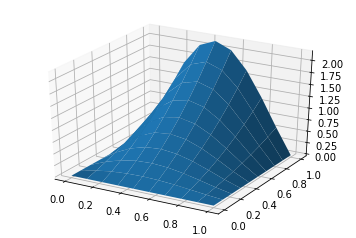

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze7sol = np.array([example7_trial_solution.predict(samples[i]) for i in range(samples.shape[0])]).reshape((samples.shape[0],))
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze7sol.reshape((new_shape, new_shape)), label='Numerical - Training')
# ax.scatter3D(xs=samples[:,0], ys=samples[:,1], zs=Ze7sol, label='Numerical - Training')
# plt.legend()
plt.show()

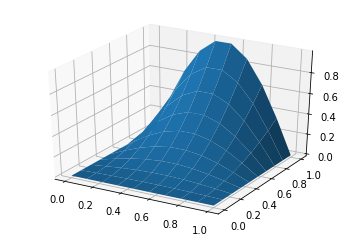

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze7anal = samples[:,1]**2 * np.sin(np.pi*samples[:, 0])
Ze7diff = Ze7sol - Ze7anal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze7anal.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [14]:
np.abs(Ze7diff).max()

1.1646393268223143836

In [15]:
np.abs(Ze7diff).mean()

0.31668888055259101743

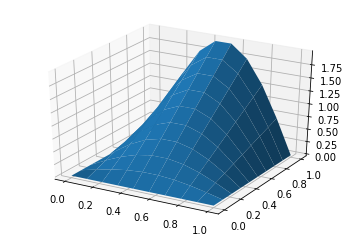

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Ze7B = 2* samples[:,1] * np.sin(np.pi*samples[:, 0])
Ze7diff = Ze7sol - Ze7anal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze7B.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze7n = np.array([(example7_trial_solution.network.forward_pass(samples[i], 0)
                 example7_trial_solution.network.forward_pass(samples[i], )
                 ) for i in range(samples.shape[0])]).reshape((samples.shape[0],))
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze7n.reshape((new_shape, new_shape)), label='Numerical - Training')
# ax.scatter3D(xs=samples[:,0], ys=samples[:,1], zs=Ze7sol, label='Numerical - Training')
# plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-b60723bd7d95>, line 5)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
Ze7n = np.array([example7_trial_solution.network.forward_pass(samples[i], 0) for i in range(samples.shape[0])]).reshape((samples.shape[0],))
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=Ze7n.reshape((new_shape, new_shape)), label='Numerical - Training')
# ax.scatter3D(xs=samples[:,0], ys=samples[:,1], zs=Ze7sol, label='Numerical - Training')
# plt.legend()
plt.show()